In [1]:
import torch
import torch.distributions as td
import torch.optim as opt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In this notebook I'll try to perform numerical variational bayesian analysis that previously I've done with **Pyro** package.

In [2]:
# In the meantime I'll define thin wrappers around the probability distributions
class Bernoulli:
    def __init__(self, p):
        self.p = p
    
    def sample(self, size=1):
        return stats.bernoulli.rvs(p=self.p, size=size)
        
class Uniform:
    def __init__(self, start, end):
        self.start = start
        self.end = end
    
    def sample(self, size=1):
        return stats.uniform.rvs(loc=self.start, scale=self.end-self.start, size=size)
    
    def pdf(self, x):
        return stats.uniform.pdf(x, loc=self.start, scale=self.end-self.start)
    
    def mean(self):
        return stats.uniform.mean(loc=self.start, scale=self.end-self.start)
        
class Beta:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    def pdf(self, X):
        return stats.beta.pdf(X, a=self.alpha, b=self.beta)
    
    def mean(self):
        return stats.beta.mean(a=self.alpha, b=self.beta)
    
    
class Normal:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def pdf(self, X):
        return stats.norm.pdf(X, loc=self.mu, scale=self.sigma)
    
    def sample(self, size=1):
        return stats.norm.rvs(loc=self.mu, scale=self.sigma, size=size)
    
    def mean(self):
        return self.mu

Let's consider a simple example, where:
- Prior $\mathbb{P}(\theta) \sim U(0, 1)$
- Likelihood $\mathbb{P}(X | \theta) \sim B(\theta)$

In [3]:
N = 100

In [4]:
Prior = Uniform(0, 1)

In [5]:
hidden_theta = Prior.sample()[0]
hidden_theta

0.9510983673224221

In [6]:
Likelihood = Bernoulli(hidden_theta)

In [7]:
X = Likelihood.sample(size=N)

In [8]:
X

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

The whole point of **variational bayesian inference**, is to fit a **variational distribution** $q_\phi$ parametrized by a set of **variational parameters** $\phi$ which is meant to approximate the true posterior $p(\theta | x)$.

Approximation is done by minimizing KL divergence between $q_\phi(\theta)$ and $p(\theta | x)$

The good thing is, we don't need to know the posterior, as long as we can calculate gradient of a KL divergence between $q$ and $p$ with respect to variational parameters $\phi$.

\begin{align}
D_{KL}(q_\phi(\theta) || p(\theta | x)) 
&= \int_\Theta q(\theta) \log \frac{q(\theta)}{p(\theta|x)} d\theta \\
&= \mathbb{E}_q \log \frac{q(\theta)}{p(\theta|x)} \\
&= \mathbb{E}_q \log q(\theta) - \mathbb{E}_q \log p(\theta|x) \\
&= \mathbb{E}_q \log q(\theta) - \mathbb{E}_q \log \frac{p(\theta, x)}{p(x)} \\
&= \log p(x) - \left( \mathbb{E}_q \log p(\theta, x) - \mathbb{E}_q \log q(\theta) \right)\\
\end{align}   

The second bit of that is called **ELBO**, which stands for **Evidence Lower BOund**. **Evidence** usually means the probability of data given the model, which is 
$$
p(x) = \int_\Theta p(x | \theta) p(\theta) d\theta
$$

We assume the model a the beginning of our inference so the value of $p(x)$ is given and does not depend on any parameters we consider.

Because KL divergence is always positive, **ELBO** has to be lower or equal to the logarithm of **evidence**. Thus maximizing the **ELBO** is our goal in computational variational inference, which should result in distribution $q_\phi$ that will approximate closely posterior probability distribution $p(\theta|x)$.

In [9]:
# Define our paramters
# We'll parametrize a Beta distribution
a = torch.tensor(2.0, dtype=torch.float32, requires_grad=True)
b = torch.tensor(2.0, dtype=torch.float32, requires_grad=True)
print(a, b)

tensor(2., requires_grad=True) tensor(2., requires_grad=True)


In [10]:
# Prior model defined using PyTorch distributions
TPrior = td.Uniform(0, 1)

In [11]:
X_tensor = torch.from_numpy(X)
print(X_tensor)

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])


In [12]:
def calculate_elbo():
    # Our variational distribution
    q_distribution = td.Beta(a, b)
    # All samples are calculated with respect to q distribution, therefore we sample from q
    theta_sample = q_distribution.rsample()

    # First bit, model log prob assuming theta is the hidden param
    log_prob_theta_model = TPrior.log_prob(theta_sample)
    log_prob_data_model = td.Bernoulli(theta_sample).log_prob(X_tensor.to(torch.float32)).sum()

    # Second bit, variational distribution log prob, assuming theta is the hidden param
    log_prob_q = q_distribution.log_prob(theta_sample)
    
    return log_prob_theta_model + log_prob_data_model - log_prob_q

In [13]:
OPTIMIZATION_STEPS = 30_000

In [14]:
optimizer = opt.Adam([a, b], lr=0.1)

In [15]:
# metrics
elbo_history = []
a_history = []
b_history = []

In [16]:
for i in range(OPTIMIZATION_STEPS):
    optimizer.zero_grad()
    
    elbo = calculate_elbo()
    loss = -elbo
    loss.backward()
    
    elbo_history.append(elbo.item())
    a_history.append(a.item())
    b_history.append(b.item())
    
    optimizer.step()
    

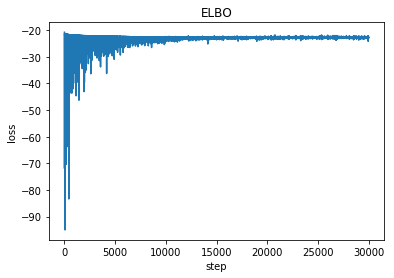

In [17]:
plt.plot(elbo_history)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

In [18]:
print("a=", a.item())
print("b=", b.item())

a= 102.12264251708984
b= 6.05571174621582


In [19]:
successes = X_tensor.sum().item()
failures = (1 - X_tensor).sum().item()

In [20]:
print("s =", successes)
print("f =", failures)

s = 95
f = 5


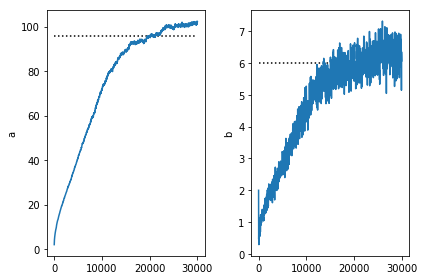

In [21]:
plt.subplot(1,2,1)
plt.plot([0,OPTIMIZATION_STEPS],[successes + 1, successes + 1], 'k:')
plt.plot(a_history)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,OPTIMIZATION_STEPS],[failures + 1, failures + 1], 'k:')
plt.plot(b_history)
plt.tight_layout()

In [22]:
A = a.item()
B = b.item()

In [23]:
MLE = (A - 1) / (A + B - 2)

In [24]:
TruePosterior = Beta(X.sum().item() + 1, (1-X).sum().item() + 1)
EstimatedPosterior = Beta(A, B)

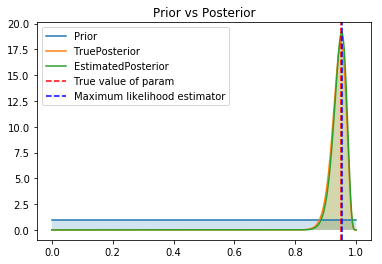

In [25]:
fig, axs = plt.subplots(1, 1)
axs.set_title("Prior vs Posterior")
support = np.linspace(0.0, 1.0, 1000)

axs.plot(support, Prior.pdf(support), label="Prior")
axs.fill_between(support, 0, Prior.pdf(support), alpha=0.2)
axs.plot(support, TruePosterior.pdf(support), label="TruePosterior")
axs.fill_between(support, 0, TruePosterior.pdf(support), alpha=0.2)
axs.plot(support, EstimatedPosterior.pdf(support), label="EstimatedPosterior")
axs.fill_between(support, 0, EstimatedPosterior.pdf(support), alpha=0.2)
axs.axvline(hidden_theta, color='red', linestyle='--', label='True value of param')
axs.axvline(MLE, color='blue', linestyle='--', label='Maximum likelihood estimator')


axs.legend()